In [204]:
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import re
import plotly.express as px
import pandas as pd
import jinja2

### Exploring Pandas Repository

In [100]:
username = "pandas-dev"
repo_name = "pandas"

### Top 10 contributors (based on contributions)

In [99]:
df_contributors = pd.read_csv("../csv_files/contributors.csv")
top_10_contributors = df_contributors[['login', 'contributions']][:10]
top_10_contributors.style.hide_index()


login,contributions
jreback,4731
jbrockmendel,3789
wesm,3127
jorisvandenbossche,1230
TomAugspurger,652
cpcloud,607
simonjayhawkins,594
mroeschke,547
gfyoung,460
sinhrks,409


### Number of commits per year

In [136]:
df_commits = pd.read_csv("../csv_files/commits.csv")
df_commits_by_year = pd.to_datetime(df_commits['commit_date']).dt.year.value_counts()
df_commits_by_year = pd.DataFrame(df_commits_by_year)
df_commits_by_year = df_commits_by_year.rename(columns={'commit_date': 'commit_count'}) # rename column 
df_commits_by_year = df_commits_by_year.rename_axis('year').reset_index()
df_commits_by_year = df_commits_by_year.sort_index(axis = 0)
df_commits_by_year = df_commits_by_year.sort_values(by=['year'])
df_commits_by_year.style.hide_index()

year,commit_count
2009,100
2010,147
2011,1321
2012,3238
2013,3239
2014,3080
2015,2067
2016,1311
2017,1776
2018,2302


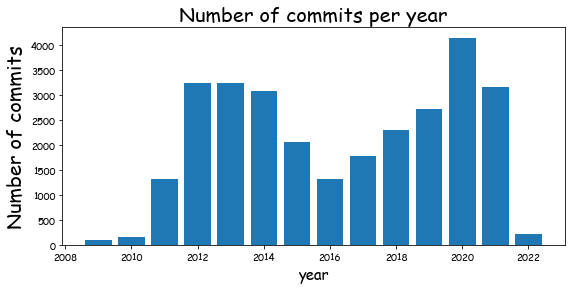

In [150]:
plt.bar(df_commits_by_year['year'], df_commits_by_year['commit_count'])
plt.rcParams["figure.figsize"] = [12,7]
plt.rcParams["font.family"] = "Comic Sans MS"
plt.xlabel("year", fontsize=15)
plt.ylabel("Number of commits", fontsize=20)
plt.title("Number of commits per year", fontsize=20)
plt.show()

### Milestones with the most open issues

In [173]:
df_milestones = pd.read_csv("../csv_files/milestones.csv")
df_milestones = df_milestones[['number', 'title', 'open_issues']]
df_milestones = df_milestones.sort_values(by=['open_issues'], ascending=False)
df_milestones = df_milestones.rename(columns={'number': 'milestone_number'})
df_milestones.style.hide_index()

milestone_number,title,open_issues
32,Contributions Welcome,1004
20,Someday,107
92,1.5,35
42,2.0,18
33,No action,11
93,1.4.1,10


### Top 10 labels in issues and pull requests

In [98]:
# fetch top 10 labels from the pandas repo
url = f"https://github.com/{username}/{repo_name}/labels?sort=count-desc"
html_response = requests.get(url).content
soup = BeautifulSoup(html_response, 'html.parser')
label_soup = soup.find_all(class_="IssueLabel hx_IssueLabel IssueLabel--big lh-condensed js-label-link d-inline-block v-align-top")
issues_and_pr_count_soup = soup.find_all(class_="Link--muted")

label_arr = [] # store top 10 labels
count = 0 

for label in label_soup:
    label_arr.append(label.text.strip())
    count += 1
    if count == 10: # break the loop after the count is 10.
        break

issues_and_pr_count_arr = [] # store top issues and pull requests count
count = 0
for soup in issues_and_pr_count_soup:
    issues_count_str = soup.text.strip()
    issues_count = int(re.sub('[^0-9]','', issues_count_str))
    issues_and_pr_count_arr.append(issues_count)
    count += 1
    if count == 10: # break the loop after the count is 10.
        break

zipped_label_arr = zip(label_arr, issues_and_pr_count_arr)

df_labels = pd.DataFrame(zipped_label_arr, columns=['Symbol', 'Total Count'])
df_labels.style.hide_index()


Symbol,Total Count
Bug,1442
Enhancement,971
Needs Discussion,338
Docs,338
Groupby,278
Indexing,239
Missing-data,217
Dtype Conversions,213
Reshaping,212
MultiIndex,211


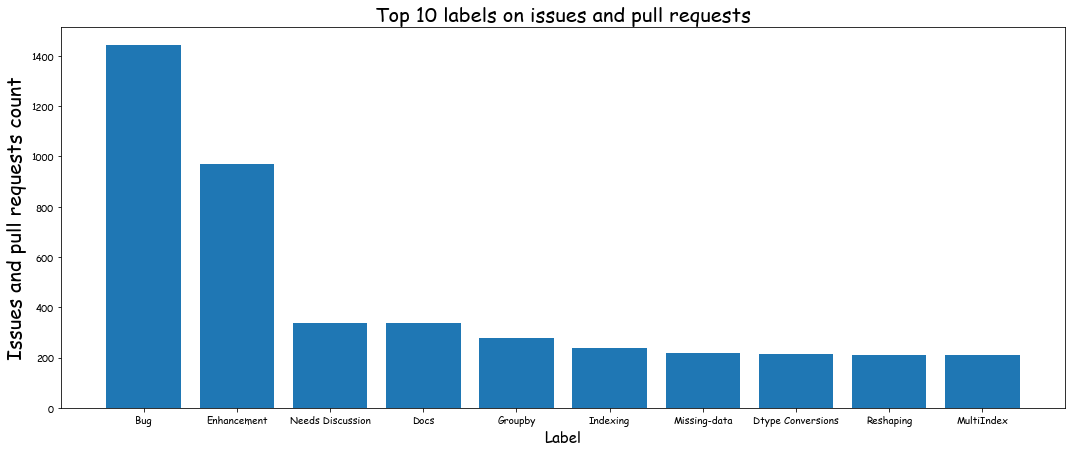

In [86]:
plt.bar(label_arr, issues_and_pr_count_arr)
plt.rcParams["figure.figsize"] = [18,7]
plt.rcParams["font.family"] = "Comic Sans MS"
plt.xlabel("Label", fontsize=15)
plt.ylabel("Issues and pull requests count", fontsize=20)
plt.title("Top 10 labels on issues and pull requests", fontsize=20)
plt.show()

### User with the most pull requests

In [199]:
# User with the most pull requests
df_pulls = pd.read_csv("../csv_files/pulls.csv")
df_pulls = pd.DataFrame(df_pulls)
df_pulls = df_pulls[['number','user_id']].groupby(by=["user_id"]).count()
df_pulls = df_pulls.sort_values(by=['number'], ascending = False)[:10]
top_10_pr_contributors = pd.merge(df_contributors[['id','login']], df_pulls, how='inner', left_on = 'id', right_on = 'user_id')
top_10_pr_contributors = top_10_pr_contributors.rename(columns={'number': 'number_of_pull_requests'})
top_10_pr_contributors = top_10_pr_contributors.sort_values(by=['number_of_pull_requests'], ascending=False)
top_10_pr_contributors[['login','number_of_pull_requests']].style.hide_index()

login,number_of_pull_requests
jbrockmendel,4153
jreback,1492
jorisvandenbossche,902
simonjayhawkins,820
TomAugspurger,800
mroeschke,582
gfyoung,445
sinhrks,400
phofl,362


### Time taken for issues to be closed (in days)

In [268]:
df_issues_year = pd.read_csv("../csv_files/issues.csv")
issues_length = len(df_issues_year)

def get_percent(val):
    return str(round(val / issues_length * 100,2))+'%'

df_issues_year['issued_opened_days'] = (pd.to_datetime(df_issues_year['closed_at']) - pd.to_datetime(df_issues_year['created_at'])).dt.days
df_issues_year['issued_opened_days'] = df_issues_year['issued_opened_days'].astype('Int64')
df_issues_year = df_issues_year[['issued_opened_days', 'number']].groupby(by=["issued_opened_days"]).count()
df_issues_year['number'] = df_issues_year['number'].apply(get_percent)
df_issues_year = df_issues_year.rename(columns={'number': 'percent'})

df_issues_year[:5]

,percent
issued_opened_days,
0,20.56%
1,8.86%
2,3.66%
3,2.75%
4,2.0%


### Languages used in Pandas Repository


In [235]:
url = f"https://github.com/{username}/{repo_name}/"
html_response = requests.get(url).content
soup = BeautifulSoup(html_response, 'html.parser')
language_soup = soup.find_all(class_="color-fg-default text-bold mr-1")
percent_soup = soup.find_all(class_="d-inline-flex flex-items-center flex-nowrap Link--secondary no-underline text-small mr-3")
languages = []
percent = []
for i in label_soup:
    languages.append(i.text.strip())
for i in percent_soup:
    percent.append(re.findall("\d+\.\d+",i.text)[0]+'%')

zipped_label_arr = zip(languages, percent)

df_labels = pd.DataFrame(zipped_label_arr, columns=['Language', 'Percentage'])
df_labels.style.hide_index()


Language,Percentage
Python,90.2%
Cython,5.6%
HTML,2.3%
C,1.8%
Shell,0.1%
Smarty,0.0%
